$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
$$

## Simple implementation of an RBM trained using contrastive divergence on MNIST

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mnist
from scipy.special import expit as sigmoid

sns.set(style="white", color_codes=True)

np.random.seed(42)

In [2]:
train_examples = mnist.train_images()
train_examples[train_examples<127]=0
train_examples[train_examples>=127]=1
train_examples = np.reshape(train_examples, (train_examples.shape[0], -1))
train_labels = mnist.train_labels()
train_examples_map = {str(label): train_examples[train_labels==label]
                  for label in set(train_labels)}
del train_labels

In [3]:
def batch_generator(data, batch_size):
    N = data.shape[0]
    
    np.random.shuffle(data)
    def _gen():
        for i in range(0, N, batch_size):
            yield data[i:i + batch_size]
        
    return _gen

In [4]:
class RBM:
    def __init__(self, num_visible, num_hidden):
        self.D = num_visible
        self.H = num_hidden

        self._initialise_params()
        
    def fit(self, data, k, learning_rate=1e-3, epochs=20, batch_size=0):
        """Fit the model using CD-k."""
        assert len(data.shape) == 2
        assert data.shape[1] == self.D
        if batch_size == 0:
            batch_size = data.shape[0]
        
        batch_gen = batch_generator(data, batch_size)
        for _ in range(epochs):
            for batch in batch_gen():
                self._single_weight_update(batch, k, learning_rate)
        
    def energy(self, visible, hidden):
        visible = self._validate_visible_input(visible)
        hidden = self._validate_hidden_input(hidden)

        return -np.trace(hidden @ self.W @ visible.T)
            
    def conditional_sample_visible(self, hidden):
        hidden = self._validate_hidden_input(hidden)
        probs = self._compute_probs_visible(hidden)
        return RBM._block_sample(probs)
    
    def conditional_sample_hidden(self, visible):
        visible = self._validate_visible_input(visible)   
        probs = self._compute_probs_hidden(visible)
        return RBM._block_sample(probs)
    
    def params(self):
        return self.W
    
    def reset_params(self):
        self._initialise_params()
    
    def _contrastive_divergence_step(self, visible, k):
        """Runs one iteration of CD-k, returning gradient update for the given training example."""
        N = visible.shape[0]
        
        hidden_probs = self._compute_probs_hidden(visible)
        hidden = RBM._block_sample(hidden_probs)
        
        vh0 = hidden_probs.T @ visible / N
        
        for _ in range(k):
            visible = self.conditional_sample_visible(hidden)
            hidden = self.conditional_sample_hidden(visible)
        
        vhk = np.mean(hidden[..., None] @ visible[:, None, :], axis=0)
        
        return vh0 - vhk
    
    def _single_weight_update(self, batch, k, learning_rate):
        self.W += learning_rate * self._contrastive_divergence_step(batch, k)
        
    def _compute_probs_visible(self, hidden):
        activations = self._compute_activations_visible(hidden)
        return sigmoid(activations)
    
    def _compute_probs_hidden(self, visible):
        activations = self._compute_activations_hidden(visible)
        return sigmoid(activations)
    
    def _compute_activations_visible(self, hidden):
        return hidden @ self.W
    
    def _compute_activations_hidden(self, visible):
        return visible @ self.W.T
    
    def _initialise_params(self):
        self.W = np.random.randn(self.H, self.D) / np.sqrt(self.H * self.D)
        
    def _block_sample(probs):
        return np.random.uniform(size=probs.shape) < probs

    def _validate_visible_input(self, visible):
        if visible.shape == (self.D,):
            visible = np.expand_dims(visible, 0)
        assert len(visible.shape) == 2
        assert visible.shape[1] == self.D
        return visible
        
    def _validate_hidden_input(self, hidden):
        if hidden.shape == (self.H,):
            hidden = np.expand_dims(hidden, 0)
        assert len(hidden.shape) == 2
        assert hidden.shape[1] == self.H
        return hidden

### Train on examples of the digit 2

In [5]:
twos = train_examples_map['2']
D = twos.shape[1]

In [6]:
rbm = RBM(num_visible=D,
          num_hidden=50)

Before we train the model, we'll compare the energy of the joint configuration when starting from an image of a two, and when starting from a random visible vector, and sampling the hidden vector for each. Granted, this will give us different answers based on the sampling of the hidden vector, but the relative difference is illustrative nonetheless.

In [7]:
example_two = twos[42]
random_example = np.random.randint(0, 2, D)

print("Energy of joint configuration based on digit two, pre-training: {:.2f}".format(
    rbm.energy(example_two, rbm.conditional_sample_hidden(example_two))))
print("Energy of joint configuration based on a random example, pre-training: {:.2f}".format(
    rbm.energy(random_example, rbm.conditional_sample_hidden(random_example))))

Energy of joint configuration based on digit two, pre-training: -0.41
Energy of joint configuration based on a random example, pre-training: -0.93


In [8]:
%%time
rbm.reset_params()
rbm.fit(twos, k=1, learning_rate=1e-2, epochs=20, batch_size=0)

CPU times: user 25.2 s, sys: 2.49 s, total: 27.7 s
Wall time: 22.5 s


We now compare the energies after training.

In [9]:
print("Energy of joint configuration based on digit two, post-training: {:.2f}".format(
    rbm.energy(example_two, rbm.conditional_sample_hidden(example_two))))
print("Energy of joint configuration based on a random example, post-training: {:.2f}".format(
    rbm.energy(random_example, rbm.conditional_sample_hidden(random_example))))

Energy of joint configuration based on digit two, post-training: -130.74
Energy of joint configuration based on a random example, post-training: 4.30


We can also visualise columns of the weight matrix.

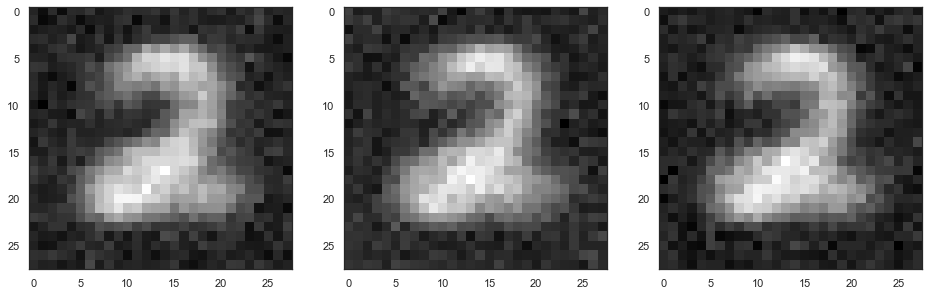

In [10]:
W = rbm.params()
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
for i, index in enumerate(np.random.choice(50, size=3, replace=False)):
    w = W[index].reshape(28, 28)
    w = (w - np.min(w)) / np.ptp(w)
    axes[i].imshow(w, cmap='gray')
plt.show()

### Train on all examples with a larger network

In [11]:
rbm_large = RBM(num_visible=D,
                num_hidden=500)

In [12]:
# %%time
rbm_large.reset_params()
rbm_large.fit(train_examples, k=1, learning_rate=1e-2, epochs=30, batch_size=100)

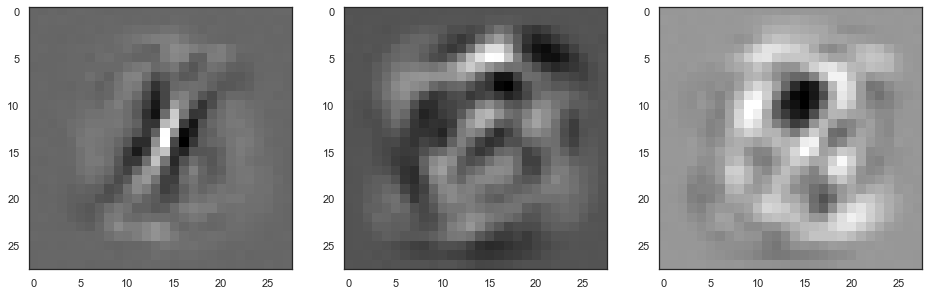

In [13]:
W_large = rbm_large.params()
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
for i, index in enumerate(np.random.choice(500, size=3, replace=False)):
    w = W_large[index].reshape(28, 28)
    w = (w - np.min(w)) / np.ptp(w)
    axes[i].imshow(w, cmap='gray')
plt.show()

In [14]:
for digit in range(10):
    example = train_examples_map[str(digit)][42]
    print("Energy of joint configuration based on digit {}, post-training: {:.2f}".format(
        str(digit), rbm_large.energy(example, rbm_large.conditional_sample_hidden(example))))
print("Energy of joint configuration based on a random example, post-training: {:.2f}".format(
    rbm_large.energy(random_example, rbm_large.conditional_sample_hidden(random_example))))

Energy of joint configuration based on digit 0, post-training: -278.95
Energy of joint configuration based on digit 1, post-training: -264.82
Energy of joint configuration based on digit 2, post-training: -249.09
Energy of joint configuration based on digit 3, post-training: -231.07
Energy of joint configuration based on digit 4, post-training: -222.63
Energy of joint configuration based on digit 5, post-training: -227.65
Energy of joint configuration based on digit 6, post-training: -199.73
Energy of joint configuration based on digit 7, post-training: -268.29
Energy of joint configuration based on digit 8, post-training: -230.24
Energy of joint configuration based on digit 9, post-training: -268.60
Energy of joint configuration based on a random example, post-training: -0.00
